In [1]:
from sklearn.datasets import make_regression, load_boston, make_swiss_roll, make_blobs, make_moons
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split
from cvxopt import matrix
from cvxopt import solvers
from numpy import linalg as LA
from sklearn.preprocessing import StandardScaler

In [2]:
X, y = make_regression(n_samples=1000, n_features=3, noise=0.1)
seed = 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [3]:
def gaussian_fourier(w):
    return (2*np.pi)**(-w.shape[0]/2) * np.exp(-LA.norm(w)/2)

def laplacian_fourier(w):
    p = 1
    for i in range(w.shape[0]):
        p *= 1 / (np.pi * (1 + w[i]))
    return p

In [4]:
def metropolis_hastings(p, dim, iter=1000):
    x = np.zeros(dim)
    samples = np.zeros((iter, dim))

    for i in range(iter):
        x_next = x + np.random.multivariate_normal(np.zeros(dim), np.eye(dim))
        if np.random.rand() < p(x_next) / p(x):
            x = x_next
        samples[i] = x

    return samples

In [5]:
D = 300
d = 3
max_iter = 10000
X_train_original, X_test_original, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

s = metropolis_hastings(gaussian_fourier, dim=d, iter=max_iter)
w = s[np.random.randint(low=100, high=max_iter, size=D)]
b = np.random.uniform(low=0, high=2*np.pi, size=D)
X_train = np.zeros((X_train_original.shape[0], D))
X_test = np.zeros((X_test_original.shape[0], D))

for i in range(X_train_original.shape[0]):
    for j in range(D):
        X_train[i, j] = np.cos(np.dot(w[j], X_train_original[i]) + b[j]) * np.sqrt(2/D)

for i in range(X_test_original.shape[0]):
    for j in range(D):
        X_test[i, j] = np.cos(np.dot(w[j], X_test_original[i]) + b[j]) * np.sqrt(2/D)

In [6]:
X_train.shape

(800, 300)

In [7]:
K = np.dot(X_train, X_train.T)

In [8]:
C = 1000
epsilon = 0.1
m,n = X_train.shape

P = matrix(np.hstack((np.vstack((K, -K)), np.vstack((-K, K)))))
q = matrix(np.vstack(((epsilon+y_train).reshape(y_train.shape[0], 1), (epsilon-y_train).reshape(y_train.shape[0], 1))))
G = matrix(np.vstack((np.eye(2*m)*-1,np.eye(2*m))))
h = matrix(np.hstack((np.zeros(2*m), np.ones(2*m) * C)))
A = matrix(np.hstack((np.ones((1, m)), -np.ones((1, m)))))
b = matrix(0.)

#Run solver
sol = solvers.qp(P, q, G, h, A, b)
alphas = np.array(sol['x'])

alphas = alphas.reshape(alphas.shape[0])

     pcost       dcost       gap    pres   dres
 0: -1.7041e+06 -2.3791e+08  2e+08  3e-10  9e-14
 1: -4.0979e+06 -3.6581e+07  3e+07  8e-11  1e-13
 2: -5.5955e+06 -1.2173e+07  7e+06  1e-10  1e-13
 3: -6.1837e+06 -8.8901e+06  3e+06  2e-10  1e-13
 4: -6.4516e+06 -7.6453e+06  1e+06  4e-11  1e-13
 5: -6.5964e+06 -7.1464e+06  6e+05  1e-10  9e-14
 6: -6.6703e+06 -6.9416e+06  3e+05  7e-10  1e-13
 7: -6.7129e+06 -6.8281e+06  1e+05  4e-10  9e-14
 8: -6.7354e+06 -6.7794e+06  4e+04  1e-10  8e-14
 9: -6.7440e+06 -6.7614e+06  2e+04  3e-10  9e-14
10: -6.7483e+06 -6.7539e+06  6e+03  6e-10  8e-14
11: -6.7498e+06 -6.7513e+06  1e+03  3e-10  8e-14
12: -6.7502e+06 -6.7506e+06  4e+02  3e-10  8e-14
13: -6.7503e+06 -6.7504e+06  1e+02  5e-10  8e-14
14: -6.7504e+06 -6.7504e+06  1e+01  3e-10  8e-14
15: -6.7504e+06 -6.7504e+06  9e-01  2e-10  8e-14
Optimal solution found.


In [9]:
alphas_plus = alphas[0:m]
alphas_minus = alphas[m:len(alphas)]

alpha = alphas_minus - alphas_plus

sup_vec_idx = np.union1d(np.argwhere(np.logical_or(alphas_minus > 1e-2, alphas_minus < -1e-2)), np.argwhere(np.logical_or(alphas_plus > 1e-2, alphas_plus < -1e-2)))
sup_vec_idx = sup_vec_idx.reshape(sup_vec_idx.shape[0])

X_sup_vec = X_train[sup_vec_idx]
y_sup_vec = y_train[sup_vec_idx]
alpha_sup_vec = alpha[sup_vec_idx]

In [10]:
w = np.zeros(D)
for i in range(alpha_sup_vec.shape[0]):
    w += alpha_sup_vec[i] * X_sup_vec[i]

In [11]:
idx1 = np.union1d(np.argwhere(alphas_minus < C-1), np.argwhere(alphas_plus > 1e-4))
idx2 = np.union1d(np.argwhere(alphas_minus > 1e-4), np.argwhere(alphas_plus < C-1))
b = (np.min(-epsilon + y_train[idx2] - np.dot(X_train[idx2], w)) + np.max(-epsilon + y_train[idx1] - np.dot(X_train[idx1], w))) / 2
b

-79.46779075944892

In [12]:
y_sup_vec = y_sup_vec.reshape(y_sup_vec.shape[0])
sup_vec_num = sup_vec_idx.shape[0]
pred_mtx = np.zeros(sup_vec_num)

In [13]:
pred = []
for x_test in X_test:
    y_hat = np.dot(x_test, w) + b
    pred.append(y_hat)
pred = np.array(pred).squeeze()

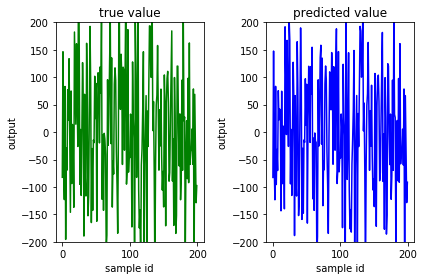

In [35]:
ax1 = plt.subplot(1, 2, 1)
ax1.plot(range(X_test.shape[0]), y_test, c="green")
ax1.set_ylim([-200, 200])
plt.xlabel("sample id")
plt.ylabel("output")
plt.title("true value")
ax2 = plt.subplot(1, 2, 2)
ax2.plot(range(X_test.shape[0]), pred, c="blue")
ax2.set_ylim([-200, 200])
plt.xlabel("sample id")
plt.ylabel("output")
plt.title("predicted value")
plt.tight_layout()

In [26]:
np.sqrt(LA.norm(pred - y_test)**2)

345.01625289511867